# Baseline

- Bidirectional LSTM

In [1]:
class_map = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4,
}
label_to_class = {v: k for k, v in class_map.items()}

## Training Model

In [2]:
import pandas as pd
from datetime import datetime, timezone, timedelta

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

KST = timezone(timedelta(hours=9))
NOW = datetime.now(KST).strftime('%Y%m%d%H%M%S') # YYYYMMDDHHmmss

# parameters
RANDOM_SEED = 42
TRAIN_CSV_DATA_PATH = "data/train_with_normal_nikl.csv"
TEST_JSON_DATA_PATH = "data/test.json"
SUBMISSION_CSV_DATA_PATH = "data/submission.csv"
EPOCHS = 50
MODEL_PATH = f"models/baseline_{NOW}.keras"

VOCAB_SIZE = 10_000
SEQ_LEN = 100

# fix random seed
tf.random.set_seed(RANDOM_SEED)

# Data preprocessing
data = pd.read_csv("data/train_with_normal_nikl.csv")
data["class_label"] = data["class"].apply(lambda x: class_map[x]) # str -> int

# Tokenization
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(data["conversation"])
train_sequences = tokenizer.texts_to_sequences(data["conversation"])
train_sequences = pad_sequences(train_sequences, padding='post', maxlen=SEQ_LEN)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(train_sequences, 
                                                  data["class_label"], 
                                                  test_size=0.2,
                                                  random_state=RANDOM_SEED, 
                                                  stratify=data["class_label"])

def get_model(X, vocab_size, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=X.shape[-1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=["accuracy"])
    return model

model = get_model(X_train, VOCAB_SIZE, num_classes=len(class_map))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODEL_PATH,
                                       monitor="val_loss",
                                       save_best_only=True)
]
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
124/124 [==============================] - 10s 31ms/step - loss: 1.2189 - accuracy: 0.4553 - val_loss: 0.9160 - val_accuracy: 0.6131
Epoch 2/50
124/124 [==============================] - 3s 23ms/step - loss: 0.6350 - accuracy: 0.7374 - val_loss: 0.6592 - val_accuracy: 0.7333
Epoch 3/50
124/124 [==============================] - 3s 23ms/step - loss: 0.2935 - accuracy: 0.9030 - val_loss: 0.5650 - val_accuracy: 0.8091
Epoch 4/50
124/124 [==============================] - 3s 23ms/step - loss: 0.1306 - accuracy: 0.9604 - val_loss: 0.7043 - val_accuracy: 0.8030
Epoch 5/50
124/124 [==============================] - 3s 23ms/step - loss: 0.0543 - accuracy: 0.9846 - val_loss: 0.7059 - val_accuracy: 0.8091
Epoch 6/50
124/124 [==============================] - 3s 23ms/step - loss: 0.0359 - accuracy: 0.9896 - val_loss: 0.7269 - val_accuracy: 0.7606
Epoch 7/50
124/124 [==============================] - 3s 23ms/step - loss: 0.0457 - accuracy: 0.9856 - val_loss: 1.1109 - val_accuracy: 0.712

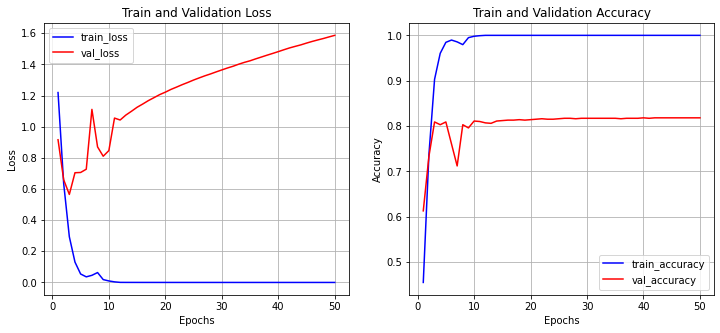

In [3]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

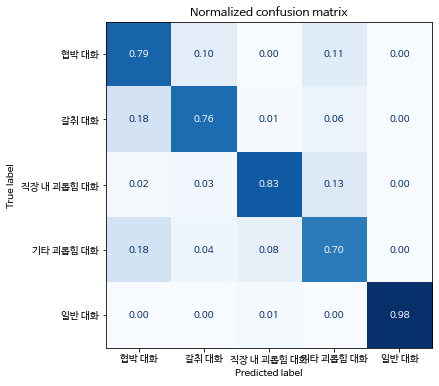

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rc("font", family="NanumBarunGothic")

def plot_confusion_matrix(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    fig , ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_map.keys())
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
    plt.title("Normalized confusion matrix")
    plt.show() 
    
model = tf.keras.models.load_model(MODEL_PATH)
y_pred = np.argmax(model.predict(X_val), axis=1)
plot_confusion_matrix(y_val, y_pred)

# 모델이 일반대화는 잘 판별하는 반면, 나머지 대화들은 아쉬운 성능을 보인다
# 협박: "갈취", "기타 괴롭힘"과 혼동됨
# 갈취: "협박"과 혼동됨
# 직장 내 괴롭힘: "협박"과 혼동됨
# 기타 괴롭힘: "협박"과 혼동됨

## Submission

In [4]:
import json

def load_test_df():
    with open("data/test.json") as file:
        test_json = json.load(file)
    
    file_names = []
    conversations = []
    for file_name in test_json:
        conversation = test_json[file_name]["text"]

        file_names.append(file_name)
        conversations.append(conversation)
        
    return pd.DataFrame({"file_name": file_names, "conversation": conversations})
    
test_df = load_test_df()
test_df

,file_name,conversation
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
497,t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...


In [5]:
import numpy as np

# Tokenization
test_sequences = tokenizer.texts_to_sequences(test_df["conversation"])
test_sequences = pad_sequences(test_sequences, padding="post", maxlen=SEQ_LEN)

# Prediction
model = tf.keras.models.load_model(MODEL_PATH)
predictions_prob = model.predict(test_sequences)
predictions = np.argmax(predictions_prob, axis=1)
test_df["class"] = predictions
test_df["class_str"] = test_df["class"].apply(lambda x: label_to_class[x])
test_df

,file_name,conversation,class,class_str
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,0,협박 대화
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,2,직장 내 괴롭힘 대화
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,2,직장 내 괴롭힘 대화
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,2,직장 내 괴롭힘 대화
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,3,기타 괴롭힘 대화
...,...,...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...,2,직장 내 괴롭힘 대화
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...,1,갈취 대화
497,t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...,1,갈취 대화
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...,3,기타 괴롭힘 대화


In [6]:
print(f"submission file: submissions/baseline_{NOW}.csv")
test_df[["file_name", "class"]].to_csv(f"submissions/baseline_{NOW}.csv", index=False)
pd.read_csv(f"submissions/baseline_{NOW}.csv")

submission file: submissions/baseline_20240626125230.csv


,file_name,class
0,t_000,0
1,t_001,2
2,t_002,2
3,t_003,2
4,t_004,3
...,...,...
495,t_495,2
496,t_496,1
497,t_497,1
498,t_498,3
